**Emotion Detection**

In [2]:
#import required libraries
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

#layers and processing funtions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("TF version : ", tf.__version__)

TF version :  2.13.0


image name : train\sad\Training_35954669.jpg
image name : train\angry\Training_7609531.jpg
image name : train\sad\Training_71902821.jpg
image name : train\neutral\Training_85821068.jpg
image name : train\fear\Training_45246349.jpg
image name : train\neutral\Training_79621486.jpg
image name : train\surprise\Training_39536730.jpg
image name : train\surprise\Training_31719744.jpg
image name : train\neutral\Training_21800519.jpg


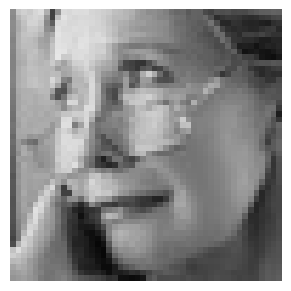

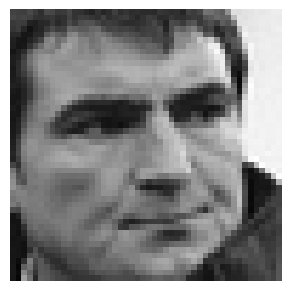

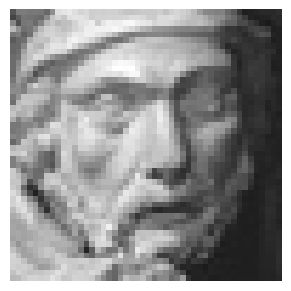

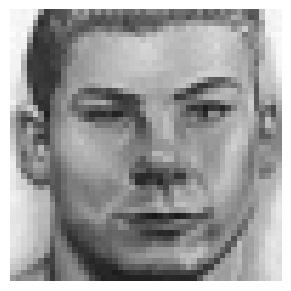

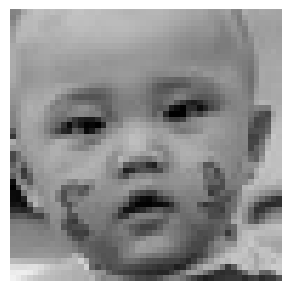

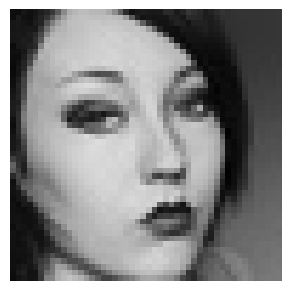

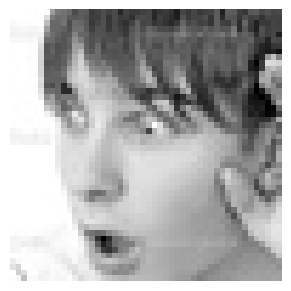

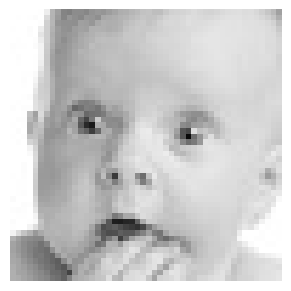

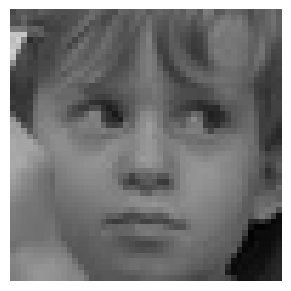

In [3]:
#labeling and uploading image data

images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    print("image name :",image)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

**preparing data for training**

In [5]:
img_size = 48
batch_size = 64

#for training
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size = (img_size,img_size),
                                                    color_mode ="grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)
#for validation
datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                    target_size = (img_size,img_size),
                                                    color_mode ="grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)

Found 28710 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Defining Model**

In [6]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size=kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    return x

In [7]:
def  Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    return x

In [8]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(inputs,64,(5,5))
    conv_3 = Convolution(inputs,128,(3,3))

    flatten = Flatten()(conv_3)
    dense_1 = Dense_f(flatten,256)
    output = Dense(7,activation = "softmax")(dense_1)

    model = Model(inputs=[inputs], outputs=[output])
    model.compile(loss = ['categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])
    return model

In [9]:
model = model_fer((48,48,1))
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       1280      
                                                                 
 batch_normalization_2 (Bat  (None, 48, 48, 128)       512       
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 48, 48, 128)       0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 128)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 128)       0     

**Intializing the model**

In [10]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor = 'val_accuracy', save_weights_only = True, mode = 'max', verbose = 1)
callbacks = [checkpoint]

## Training the model

In [11]:
import scipy
history = model.fit(
    x = train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data= validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks)
    

Epoch 1/15
448/448 [==============================] - ETA: 0s - loss: 3.5289 - accuracy: 0.2417
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 350s 780ms/step - loss: 3.5289 - accuracy: 0.2417 - val_loss: 1.8752 - val_accuracy: 0.2475
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.8551 - accuracy: 0.2512
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 167s 374ms/step - loss: 1.8551 - accuracy: 0.2512 - val_loss: 1.8433 - val_accuracy: 0.2473
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.8328 - accuracy: 0.2511
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 168s 376ms/step - loss: 1.8328 - accuracy: 0.2511 - val_loss: 1.8294 - val_accuracy: 0.2472
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 1.8224 - accuracy: 0.2514
Epoch 4: saving model to model_weights.h5
448/448 [==============================] - 

**model evaluation**

In [12]:
model.evaluate(validation_generator)

113/113 [==============================] - 8s 69ms/step - loss: 1.8132 - accuracy: 0.2471


[1.8131523132324219, 0.24714405834674835]

**Plotting loss**

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top = 1.0, bottom=0.0, right=0.95, left = 0.0, hspace = 0.25, wspace = 0.35)

<Figure size 640x480 with 1 Axes>

## Saving model

In [15]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)